## Magdalena's Github Programming Language-Prediction Project

03 March 2023

In [140]:
#imports

import pandas as pd
import requests
import numpy as np

import acquire as a
import prepare as p
import explore_functions as e

from bs4 import BeautifulSoup
import time

import env
from env import github_token, github_username

import re
import unicodedata
import nltk
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords


In [2]:
headers = {"Authorization": f"token {env.github_token}", "User-Agent":{env.github_username}}


In [3]:
url = 'https://github.com/search?o=desc&q=shoes&s=stars&type=Repositories'
response = requests.get(url)

# we get back html as the response

In [4]:
soup = BeautifulSoup(response.content, 'html.parser')


In [5]:
list_o_elements = soup.find_all('a')

In [6]:
# for loop to get githug urls

pageCount = 15
urlsList = []

base = 'https://github.com/search?o=desc&p={}&q=shoes&s=stars&type=Repositories' #curly braces let you format

for x in range(pageCount)[0:]:
    urlsList.append(base.format(x))

In [7]:
# urlsList

In [8]:
def scrape_one_page(topic):
    '''
    This function will, given a topic on the 'inshorts' news website, scrape the first page of articles within that category and put that data into a json file.
    '''
    base_url = 'https://inshorts.com/en/read/'
    
    response = get(base_url + topic)
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    titles = soup.find_all('span', itemprop='headline')
    
    summaries = soup.find_all('div', itemprop='articleBody')
    
    summary_list = []
    
    for i in range(len(titles)):
        
        temp_dict = {'category': topic,
                     'title': titles[i].text,
                     'content': summaries[i].text}
        
        summary_list.append(temp_dict)
        
    return summary_list

In [9]:
# list200 = []

# for i in urlsList:
#     response = requests.get(i)
#     time.sleep(15)
#     list200.append(response)

In [10]:
# unnecesary, but working, function

# for url in urlsList:
#     time.sleep(1)
    
#     def github_api_request(url: str):
        
#         response = requests.get(url, headers = a.headers)
#         response_data = response.json()
        
#         if response.status_code != 200:
#             raise Exception(
#                 f"Error response from github api! status code: {response.status_code}, "
#                 f"response: {json.dumps(response_data)}")
#             x
#         return response_data


In [11]:
# github_api_request(urlsList)

In [12]:


def get_repo_links(github_token = github_token, github_username = github_username,
                                         topic = 'shoes', number_of_pages = 13):
    
    '''
    Takes in a topic, your unique github API token, and your github username as
    strings and an interger for the number of pages to query
    Returns: list of repositories from GitHub in the form of
    '<username>/<repo_name>'
    '''
    
    # set URL without page number
    url = f'https://github.com/topics/{topic}?&s=stars&page='
    
    # set header for github auth
    headers = {"Authorization": f"token {env.github_token}",
               "User-Agent": env.github_username}
    
    # set empty list for total repos scraped
    list_of_repos = []
    
    # for each page in range of provided number
    for i in range(1, number_of_pages + 1):
        
        # obtain page data
        response = requests.get(url + str(i), headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        content = soup.find_all('h3')
        
        # set empty list to agg for each page
        page_list = []
        for repo in content:
            # confirms that h3 tag contains repo information
            if [re.search(r'(\S+)', x.text).group(1) for x in repo.find_all('a')] != []:
                
                # returns owner username and repo name
                user_name, repo_name = [re.search(r'(\S+)', x.text)\
                                         .group(1) for x in repo.find_all('a')]
                
                # add to page list for each repo on page
                page_list.extend([f'{user_name}/{repo_name}'])
                
        # add new page list into existing list for total repos
        list_of_repos.extend(page_list)
        print(f'Page {i} Completed')
        
    # saves returned list into .py file for calling in later functions
    with open("repos.py", "w") as repos:
        repos.write(f'REPOS = {list_of_repos}')
        
    return list_of_repos

In [13]:
# this is no longer needed to run bc we already obtained the list of repos

# list_of_repos = get_repo_links()

In [14]:
# len(list_of_repos)

In [15]:
# function to obtain scraped github data

sth = a.scrape_github_data()

In [16]:
# make dataframe of dictionary of readmes

df = pd.DataFrame(sth)

In [17]:
txt = "My name is Ståle+++"

print(txt.encode(encoding="ascii",errors="backslashreplace"))
print(txt.encode(encoding="ascii",errors="ignore"))
print(txt.encode(encoding="ascii",errors="namereplace"))
print(txt.encode(encoding="ascii",errors="replace"))
print(txt.encode(encoding="ascii",errors="xmlcharrefreplace"))

b'My name is St\\xe5le+++'
b'My name is Stle+++'
b'My name is St\\N{LATIN SMALL LETTER A WITH RING ABOVE}le+++'
b'My name is St?le+++'
b'My name is St&#229;le+++'


In [18]:
def clean_text(text, extra_stopwords=['r', 'u', '2', 'ltgt']):
    '''
    This function does what 'basic_clean' does, but takes it a step further by removing stopwords and lemmatizing the text.
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    
    words = re.sub(r'[^\w\s+]', '', clean_text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [19]:
# testing function 

clean_text('afdkj be an +++ c c+ c++ ruby java rust julia r python')

['afdkj', '+++', 'c', 'c+', 'c++', 'ruby', 'java', 'rust', 'julia', 'python']

In [20]:
def stem(string):
    '''
    This function takes in text and returns the stem word joined back into the text
    '''
    #create porter stemmer
    ps = nltk.porter.PorterStemmer()
    
    #use the stem, split string using each word
    stems = [ps.stem(word) for word in string.split()]
    
    #join stem word to string
    string = ' '.join(stems)

    return string


In [21]:
# testing out 'stem' function

stem('afdkj be an +++ c c+ c++ ruby java rust julia r python')

'afdkj be an +++ c c+ c++ rubi java rust julia r python'

In [22]:
def lemmatize(string):
    '''
    This function takes in a string and returns the lemmatized word joined back into the string
    '''
    #create the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    #look at the article 
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    #join lemmatized words into article
    string = ' '.join(lemmas)

    return string


In [23]:
# testing out 'lemmatize' function

lemmatize('afdkj be an +++ c c+ c++ ruby java rust julia r python')

'afdkj be an +++ c c+ c++ ruby java rust julia r python'

In [24]:
# applying 'clean_text' function to 'readme_contents' col of df

df['cleaned_text'] = df['readme_contents'].apply(clean_text)

In [25]:
df.head(2)

,repo,language,readme_contents,cleaned_text
0,shoes/shoes4,Ruby,# Shoes 4 [![Linux Build Status](https://secur...,"[shoe, 4, linux, build, statushttpssecuretravi..."
1,druv5319/Sneaks-API,JavaScript,"\n<p align=""center"">\n \n<img src=""https://gi...","[p, aligncenter, img, srchttpsgithubcomdruv531..."


In [26]:
df['cleaned_text']

0     [shoe, 4, linux, build, statushttpssecuretravi...
1     [p, aligncenter, img, srchttpsgithubcomdruv531...
2     [_, _, _, artsy, anyplatform, app, kit, httpsg...
3     [javascriptwebgl, lightweight, robust, hand, t...
4     [selenium, shoe, bot, deprecated, program, old...
                            ...                        
93    [web, design, development, 1, ecomm, webstore,...
94                              [kingshoestestgithubio]
95    [screenshot, 20221226, 181957httpsuserimagesgi...
96    [getting, started, create, react, app, project...
97         [cfcsports, added, social, medium, whatsapp]
Name: cleaned_text, Length: 98, dtype: object

In [27]:
#returning all the words in readme_contents individually

readme_words = clean_text(' '.join(df['readme_contents']))

In [28]:

# setting the cleaned txt to Series and counting word frequency
count = pd.Series(readme_words).value_counts()
count

shoe                          206
project                       104
use                            81
app                            78
run                            73
                             ... 
installservicemeshoperator      1
05_objectbucketclaimyml         1
appinfinitemario                1
githubkenmoiniupstreamyml       1
whatsapp                        1
Length: 4459, dtype: int64

In [29]:
df.isna().sum()

repo               0
language           6
readme_contents    0
cleaned_text       0
dtype: int64

In [30]:
df = df.dropna()

In [31]:
#returning all the words in language individually

lang_words = clean_text(' '.join(df['language']))


In [32]:

# setting the cleaned txt to Series and counting word frequency
count = pd.Series(lang_words).value_counts()
count

javascript     19
html           16
cs             12
ruby           10
python          8
typescript      6
dart            3
java            3
sc              3
php             3
go              2
c++             2
smarty          1
c               1
jupyter         1
notebook        1
applescript     1
vue             1
dtype: int64

In [51]:
def lesser_langs_list(df):
    
    '''
    this function takes in the dataframe of scraped
    github data, cleans, lemmatises & removes stopwords,
    isolates the language column into word counts, then
    turns that col into a separate DF, isolates out the 
    top 6 languages, and turns all the remaining languages
    into a list
    '''
    
    #returning all the words in language individually
    lang_words = clean_text(' '.join(df['language']))

    # setting the cleaned txt to Series and counting word frequency
    count = pd.Series(lang_words).value_counts()

    # amke into df
    lang_df = pd.DataFrame(count)

    # language counts, resetting & renaming index
    lang_df.columns = ['counts']
    lang_df = lang_df.reset_index()
    lang_df = lang_df.rename(columns = {'index':'language'})

    # all the languages that are not in the top 6
    langs = ['javascript', 'html', 'cs', 'ruby', 'python', 'typescript']
    other_langs = lang_df[~lang_df['language'].isin(langs)]

    # dropping 'counts col'
    other_langs = other_langs.drop(columns=['counts'])
    
    # turning df into a list
    other_langs = other_langs.values.tolist()
    
    return other_langs

In [52]:
other_langs

[['dart'],
 ['java'],
 ['sc'],
 ['php'],
 ['go'],
 ['c++'],
 ['smarty'],
 ['c'],
 ['jupyter'],
 ['notebook'],
 ['applescript'],
 ['vue']]

In [ ]:
# the languages in 'language' col

df['language'].value_counts()

In [65]:
# amke into df

lang_df = pd.DataFrame(count)
lang_df.head()

,0
javascript,19
html,16
cs,12
ruby,10
python,8


In [67]:
# language counts, resetting & renaming index

lang_df.columns = ['counts']
lang_df = lang_df.reset_index()


In [68]:
lang_df = lang_df.rename(columns = {'index':'language'})


In [37]:
# all the languages that are not in the top 6

langs = ['javascript', 'html', 'cs', 'ruby', 'python', 'typescript']

other_langs = lang_df[~lang_df['language'].isin(langs)]

other_langs

,language,counts
6,dart,3
7,java,3
8,sc,3
9,php,3
10,go,2
11,c++,2
12,smarty,1
13,c,1
14,jupyter,1
15,notebook,1


In [44]:
other_langs = other_langs.drop(columns=['counts'])

In [45]:
other_langs = other_langs.values.tolist()

In [46]:
other_langs

[['dart'],
 ['java'],
 ['sc'],
 ['php'],
 ['go'],
 ['c++'],
 ['smarty'],
 ['c'],
 ['jupyter'],
 ['notebook'],
 ['applescript'],
 ['vue']]

In [55]:
# df of frequency counts for all the languages

list_of_other = ['Java', 'Jupyter Notebook', 'AppleScript', 'Vue', 'Dart', 'SCSS', 'PHP', 'Go', "C++", 'Smarty', 'C']

for i in list_of_other:
    df['language'] = df['language'].replace(i, 'Other')

In [87]:
top_freq = lang_df.head(8)

In [163]:
# most frequent words, label-coloured
def lang_freq_barchart():
    
    top_freq.plot.bar(figsize = (9,6), color = 'magenta')

    plt.title('Github shoe repository programming language word counts')

    # set xtick labels and properties
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], 
               ['Javascript', 'HTML', 'CSS', 'Ruby', 'Python', 'Typescript', 'Dart', 'Java'],
                rotation=20)

    plt.legend([],[])
    plt.yticks(np.arange(0, 21, 2))

    plt.ylabel('Count')
    plt.xlabel('Repository language frequency')

    plt.show()

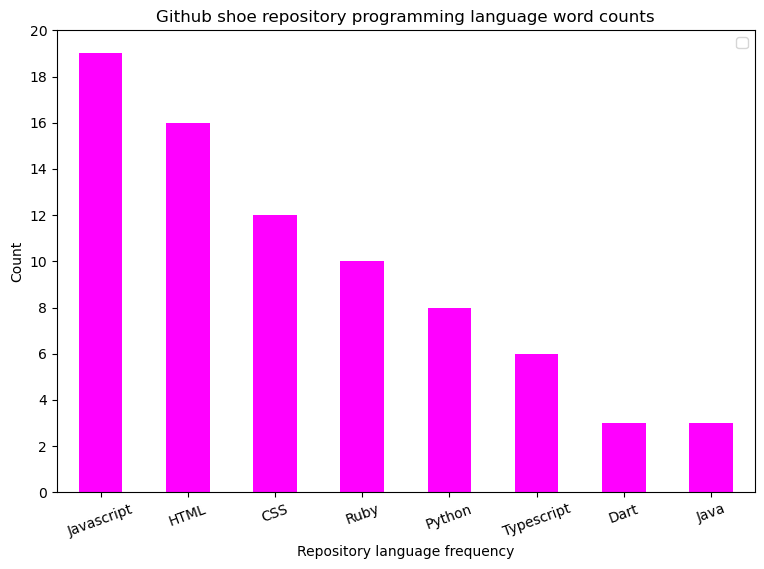

In [164]:
lang_freq_barchart()

In [141]:
df['language']

0           Ruby
1     JavaScript
2          Other
3     JavaScript
4         Python
         ...    
92           CSS
93          HTML
95    JavaScript
96    TypeScript
97           CSS
Name: language, Length: 92, dtype: object

In [161]:
# individual readme words from each language type

javascript_words = clean_text(' '.join(df[df['language'] == 'JavaScript']['readme_contents']))
                              
html_words = clean_text(' '.join(df[df['language'] == 'HTML']['readme_contents'])) 

css_words = clean_text(' '.join(df[df['language'] == 'CSS']['readme_contents'])) 

ruby_words = clean_text(' '.join(df[df['language'] == 'Ruby']['readme_contents'])) 

python_words = clean_text(' '.join(df[df['language'] == 'Python']['readme_contents'])) 

typescript_words = clean_text(' '.join(df[df['language'] == 'TypeScript']['readme_contents'])) 

other_words = clean_text(' '.join(df[df['language'] == 'Other']['readme_contents'])) 

In [162]:

javascript_count = pd.Series(javascript_words).value_counts()

html_count = pd.Series(html_words).value_counts()

cs_count = pd.Series(css_words).value_counts()

ruby_count = pd.Series(ruby_words).value_counts()

python_count = pd.Series(python_words).value_counts()

typecript_count = pd.Series(typescript_words).value_counts()

other_count = pd.Series(other_words).value_counts()

cs_count


shoe           12
projeto        10
img             8
page            8
br              7
               ..
appreciably     1
increase        1
capacitance     1
electrical      1
whatsapp        1
Length: 471, dtype: int64